# SOBJIO Ludane Lagnol
# Msc BIHAR - ESTIA 2024
Le projet vise à développer des modèle de classification d'images multi-classes pour identifier les zones nécessitant un arrosage dans un champ de maïs. Les images sont prises à l'aide d'un smartphone placé à une hauteur de 1 à 1,5 mètre du sol, simulant ainsi la perspective d'une machine de pulvérisation équipée d'une caméra.

L'objectif est d'attribuer une classe à chaque image parmi les suivantes : sol sec sans végétation, végétation de maïs, plantes herbacées, ou une combinaison de maïs et de plantes herbacées. Les données comprennent des photos prises dans un champ de maïs disponibles sur Kaggle.

Le projet implique les modules M24 Deep Learning I et M32 Machine Learning II, en mettant l'accent sur l'explicabilité des modèles. La méthodologie comprend plusieurs étapes :

1. Commencer par utiliser uniquement les trois premières classes, puis élargir aux quatre classes.
2. Redimensionner les images pour réduire leur taille.
3. Appliquer des techniques de prétraitement des données selon le choix du développeur.
4. Expérimenter avec différents optimiseurs tels que Adam, RMSprop, Adagrad, etc.
5. Tester l'efficacité du dropout en combinaison avec la normalisation par lots et différents taux de dropout.
6. Utiliser des modèles préentraînés tels que VGG16, VGG19, Xception, etc.
7. Évaluer la performance des différents modèles à l'aide de graphiques d'accuracy, de perte et de la matrice de confusion.
8. Sélectionner des images représentatives de chaque classe pour des tests supplémentaires, notamment l'affichage des images et des probabilités correspondant à la classe la plus probable, ainsi que l'affichage des superpixels explicatifs en utilisant la bibliothèque LIME (Local Interpretable Model-agnostic Explanations).

En résumé, le projet vise à développer un modèle de classification d'images robuste et explicatif pour aider à identifier les zones nécessitant un arrosage dans un champ de maïs, en explorant diverses architectures de réseaux neuronaux convolutifs et techniques d'optimisation.

In [2]:
import matplotlib.pyplot as plt
import cv2
import keras
import numpy as np
import os
import random
import seaborn as sns
from PIL import Image
from skimage.transform import resize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import VGG19, Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

import lime
import lime.lime_image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Chemins vers les dossiers contenant les images de chaque classe
folder_Chaos_train = "/content/drive/MyDrive/ImagensTCCRotuladas/Train/Chao"
folder_Ervas_train = "/content/drive/MyDrive/ImagensTCCRotuladas/Train/Ervas"
folder_Milho_train = "/content/drive/MyDrive/ImagensTCCRotuladas/Train/Milho"
folder_Milho_ervas_train = "/content/drive/MyDrive/ImagensTCCRotuladas/Train/Milho_ervas"

folder_Chaos_test = "/content/drive/MyDrive/ImagensTCCRotuladas/Test/Chao"
folder_Ervas_test = "/content/drive/MyDrive/ImagensTCCRotuladas/Test/Ervas"
folder_Milho_test = "/content/drive/MyDrive/ImagensTCCRotuladas/Test/Milho"

folder_Chaos_val = "/content/drive/MyDrive/ImagensTCCRotuladas/Validation/Chao"
folder_Ervas_val = "/content/drive/MyDrive/ImagensTCCRotuladas/Validation/Ervas"
folder_Milho_val = "/content/drive/MyDrive/ImagensTCCRotuladas/Validation/Milho"

In [ ]:
import os

def load_images_by_batches(folder_path, target_size=(224, 224)):
    ims = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    random.shuffle(ims)  # Mélanger aléatoirement les images
    ims = ims[:int(len(ims) * 0.10)]  # Sélectionner 10% des images
    X_batches = []
    y_batches = []
    label = os.path.basename(folder_path)  # Obtenir le nom du dossier parent comme étiquette
    for image_path in ims:
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)  # Redimensionner l'image
        X_batches.append(image)
        y_batches.append(label)  # Utiliser le nom du dossier comme étiquette
    return X_batches, y_batches

# Charger les images et créer les étiquettes pour chaque classe
X_Chaos_batches_train, y_Chaos_batches_train = load_images_by_batches(folder_Chaos_train)
X_Ervas_batches_train, y_Ervas_batches_train = load_images_by_batches(folder_Ervas_train)
X_Milho_batches_train, y_Milho_batches_train = load_images_by_batches(folder_Milho_train)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Sélectionner une image aléatoire de chaque classe
Chao_img_name = random.choice(os.listdir(folder_Chaos_train))
Ervas_img_name = random.choice(os.listdir(folder_Ervas_train))
Milho_img_name = random.choice(os.listdir(folder_Milho_train))
Milho_ervas_img_name = random.choice(os.listdir(folder_Milho_ervas_train))

# Chemins complets des images
Chao_img_path = os.path.join(folder_Chaos_train, Chao_img_name)
Ervas_img_path = os.path.join(folder_Ervas_train, Ervas_img_name)
Milho_img_path = os.path.join(folder_Milho_train, Milho_img_name)
Milho_ervas_img_path = os.path.join(folder_Milho_ervas_train, Milho_ervas_img_name)

# Lire les images
Chao_img = mpimg.imread(Chao_img_path)
Ervas_img = mpimg.imread(Ervas_img_path)
Milho_img = mpimg.imread(Milho_img_path)
Milho_ervas_img = mpimg.imread(Milho_ervas_img_path)

# Afficher les images
plt.figure(figsize=(10, 10))

plt.subplot(1, 4, 1)
plt.imshow(Chao_img)
plt.title('Chao')

plt.subplot(1, 4, 2)
plt.imshow(Ervas_img)
plt.title('Ervas')

plt.subplot(1, 4, 3)
plt.imshow(Milho_img)
plt.title('Milho')

plt.subplot(1, 4, 4)
plt.imshow(Milho_ervas_img)
plt.title('Milho_ervas')

plt.show()


### I) Chargement des données

In [6]:
a=0.3

In [7]:
# Définir la fonction importer_images
def importer_images(dossier_images):
    chemins_images = []
    for nom_fichier in os.listdir(dossier_images):
        chemin_image = os.path.join(dossier_images, nom_fichier)
        if os.path.isfile(chemin_image):
            # Vérifier si le fichier est une image
            extension = nom_fichier.split('.')[-1]
            if extension.lower() in ['jpg', 'jpeg', 'png', 'bmp']:
                chemins_images.append(chemin_image)

    # Sélectionner aléatoirement 10 % des chemins d'images
    chemins_images_10_percent = random.sample(chemins_images, k=int(0.05 * len(chemins_images)))

    images = []
    # Charger les images à partir des chemins sélectionnés
    for chemin_image in chemins_images_10_percent:
        image = cv2.imread(chemin_image)
        # Vérifier si l'image est chargée avec succès
        if image is not None:
            images.append(image)
        else:
            print(f"Impossible de charger l'image : {chemin_image}")

    return images

In [8]:
# Chemins vers les répertoires contenant les images de test
Test_Chao = '/content/drive/MyDrive/ImagensTCCRotuladas/Test/Chao'
Test_Ervas = '/content/drive/MyDrive/ImagensTCCRotuladas/Test/Ervas'
Test_Milho = '/content/drive/MyDrive/ImagensTCCRotuladas/Test/Milho'
#Test_Milho_ervas = '/content/drive/MyDrive/ImagensTCCRotuladas/Test/Milho_ervas'

# Importer les images avec leurs classes correspondantes
df_chao = pd.DataFrame({'Image': importer_images(Test_Chao), 'Classe': 'Chao'})
df_ervas = pd.DataFrame({'Image': importer_images(Test_Ervas), 'Classe': 'Ervas'})
df_milho = pd.DataFrame({'Image': importer_images(Test_Milho), 'Classe': 'Milho'})
#df_milho_ervas = pd.DataFrame({'Image': importer_images(Test_Milho_ervas), 'Classe': 'Milho_ervas'})

# Concaténer les DataFrames en un seul DataFrame de test
df_test = pd.concat([df_chao, df_ervas, df_milho], ignore_index=True)

# Prenez 10% du DataFrame
df_test = df_test.sample(frac=a)

# Afficher le DataFrame
df_test.head()

,Image,Classe
14,"[[[132, 203, 153], [127, 198, 148], [125, 198,...",Milho
11,"[[[28, 142, 79], [19, 134, 71], [6, 123, 60], ...",Milho
10,"[[[7, 49, 8], [10, 52, 11], [6, 50, 11], [9, 5...",Milho
4,"[[[102, 100, 119], [64, 63, 79], [29, 28, 44],...",Chao


In [9]:
df_test.shape

(4, 2)

In [1]:
# Chemins vers les répertoires contenant les images d'entraînement
Train_Chao = '/content/drive/MyDrive/ImagensTCCRotuladas/Train/Chao'
Train_Ervas = '/content/drive/MyDrive/ImagensTCCRotuladas/Train/Ervas'
Train_Milho = '/content/drive/MyDrive/ImagensTCCRotuladas/Train/Milho'
#Train_Milho_ervas = '/content/drive/MyDrive/ImagensTCCRotuladas/Train/Milho_ervas'

# Importer les images avec leurs classes correspondantes
df_chao_train = pd.DataFrame({'Image': importer_images(Train_Chao), 'Classe': 'Chao'})
df_ervas_train = pd.DataFrame({'Image': importer_images(Train_Ervas), 'Classe': 'Ervas'})
df_milho_train = pd.DataFrame({'Image': importer_images(Train_Milho), 'Classe': 'Milho'})
#df_milho_ervas_train = pd.DataFrame({'Image': importer_images(Train_Milho_ervas), 'Classe': 'Milho_ervas'})

# Concaténer les DataFrames en un seul DataFrame d'entraînement
df_train = pd.concat([df_chao_train, df_ervas_train, df_milho_train], ignore_index=True)

# Prenez 5% du DataFrame
df_train = df_train.sample(frac=a)
# Afficher le DataFrame
df_train.head()

NameError: name 'pd' is not defined

In [ ]:
df_train.shape

In [ ]:
# Chemins vers les répertoires contenant les images d'entraînement
Validation_Chao = '/content/drive/MyDrive/ImagensTCCRotuladas/Train/Chao'
Validation_Ervas = '/content/drive/MyDrive/ImagensTCCRotuladas/Train/Ervas'
Validation_Milho = '/content/drive/MyDrive/ImagensTCCRotuladas/Train/Milho'
#Validation_Milho_ervas = '/content/drive/MyDrive/ImagensTCCRotuladas/Train/Milho_ervas'

# Importer les images avec leurs classes correspondantes
df_chao_Validation = pd.DataFrame({'Image': importer_images(Validation_Chao), 'Classe': 'Chao'})
df_ervas_Validation = pd.DataFrame({'Image': importer_images(Validation_Ervas), 'Classe': 'Ervas'})
df_milho_Validation = pd.DataFrame({'Image': importer_images(Validation_Milho), 'Classe': 'Milho'})
#df_milho_ervas_Validation = pd.DataFrame({'Image': importer_images(Validation_Milho_ervas), 'Classe': 'Milho_ervas'})

# Concaténer les DataFrames en un seul DataFrame d'entraînement
df_Validation = pd.concat([df_chao_Validation, df_ervas_Validation, df_milho_Validation], ignore_index=True)

# Prenez 5% du DataFrame
df_Validation = df_Validation.sample(frac=a)
# Afficher le DataFrame
df_Validation.head()

In [ ]:
df_Validation.shape

In [ ]:
data= pd.concat([df_test,df_train,df_Validation])
data.head()

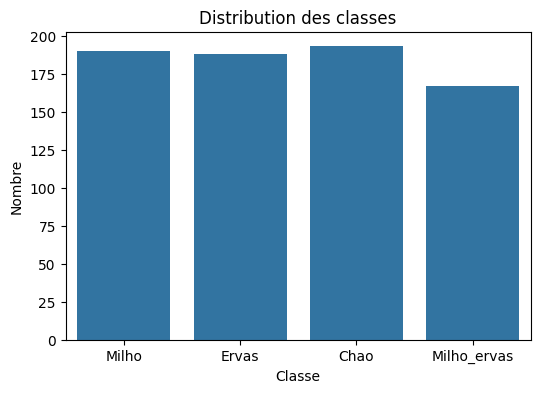

In [ ]:
import seaborn as sns

# Assurez-vous que Classe_counts est correctement généré
Classe_counts = data['Classe'].value_counts(sort=False).reset_index()
Classe_counts.columns = ['Classe', 'number']

# Tracer le graphique à barres
plt.figure(figsize=(6, 4))
sns.barplot(x=Classe_counts.Classe, y=Classe_counts.number)
plt.title('Distribution des classes')
plt.ylabel('Nombre')
plt.xlabel('Classe')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Définir les classes à utiliser
classes_to_use = ['Ervas', 'Chao', 'Milho']  # Utiliser uniquement les 3 premières classes

# Filtrer le DataFrame pour ne garder que les classes spécifiées
data = data[data['Classe'].isin(classes_to_use)]

In [ ]:
data.head()

,Image,Classe
0,[[[ 58 66 103] [ 44 51 90] [ 26 34 74] ...,Milho
1,[[[ 71 69 91] [ 95 93 115] [123 121 141] ...,Ervas
2,[[[ 0 1 6] [ 3 6 11] [ 3 2 11] ...,Chao
3,[[[114 122 145] [ 64 71 98] [ 53 54 88] ...,Ervas
5,[[[249 255 238] [250 255 239] [250 255 239] ...,Ervas


TypeError: Image data of dtype <U581 cannot be converted to float

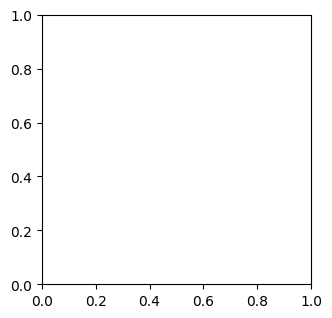

In [ ]:

import numpy as np
# Fonction pour afficher les images à partir du DataFrame
def display_images_horizontally(dataframe, num_images=4):
    """
    Affiche les images horizontalement à partir d'un DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame contenant les données des images et les classes.
        num_images (int): Nombre d'images à afficher.

    Returns:
        None
    """
    # Créer une figure avec une taille personnalisée
    plt.figure(figsize=(16, 4))

    # Parcourir les premières lignes du DataFrame jusqu'à num_images
    for i, (index, row) in enumerate(dataframe.head(num_images).iterrows()):
        # Extraire les données de l'image et la classe
        img_data = row['Image']
        label = row['Classe']

        # Convertir les données de l'image en un tableau numpy
        img_array = np.array(img_data)

        # Ajouter un subplot à la figure
        plt.subplot(1, num_images, i + 1)

        # Afficher l'image
        plt.imshow(img_array)
        plt.title(label)  # Définir le titre comme la classe de l'image
        plt.axis('off')  # Masquer les axes

    plt.show()  # Afficher la figure

# Utilisation de la fonction pour afficher les images horizontalement
display_images_horizontally(data, num_images=4)


###  II) Analyse exploratoire des données

### III) Définition des ensembles d’entraînement, de validation et de test

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np

# Fonction pour charger et redimensionner une image à partir d'un DataFrame
def load_and_resize_image_from_dataframe(dataframe, new_size):
    """
    Charge et redimensionne les images à partir d'un DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame contenant les données des images et les classes.
        new_size (tuple): Nouvelle taille de l'image sous forme de tuple (largeur, hauteur).

    Returns:
        resized_images_df (pd.DataFrame): DataFrame contenant les images redimensionnées et les classes.
    """
    # Initialiser une liste pour stocker les images redimensionnées et les étiquettes correspondantes
    resized_images = []

    # Parcourir les lignes du DataFrame
    for index, row in dataframe.iterrows():
        # Extraire les données de l'image et la classe
        img_data = row['Image']
        label = row['Classe']

        # Convertir les données d'image en tableau numpy
        img_array = np.array(img_data, dtype=np.uint8)

        # Créer un objet d'image PIL à partir du tableau d'images
        img = Image.fromarray(img_array)

        # Redimensionner l'image
        resized_img = img.resize(new_size)

        # Ajouter l'image redimensionnée et la classe à la liste
        resized_images.append({'Image': resized_img, 'Classe': label})

    # Créer un DataFrame à partir de la liste des images redimensionnées
    resized_images_df = pd.DataFrame(resized_images)

    return resized_images_df


In [ ]:
# Exemple d'utilisation avec des valeurs possibles
new_size = (100, 100)  # Redimensionner les images à une taille de 100x100 pixels
new_data = load_and_resize_image_from_dataframe(data, new_size)


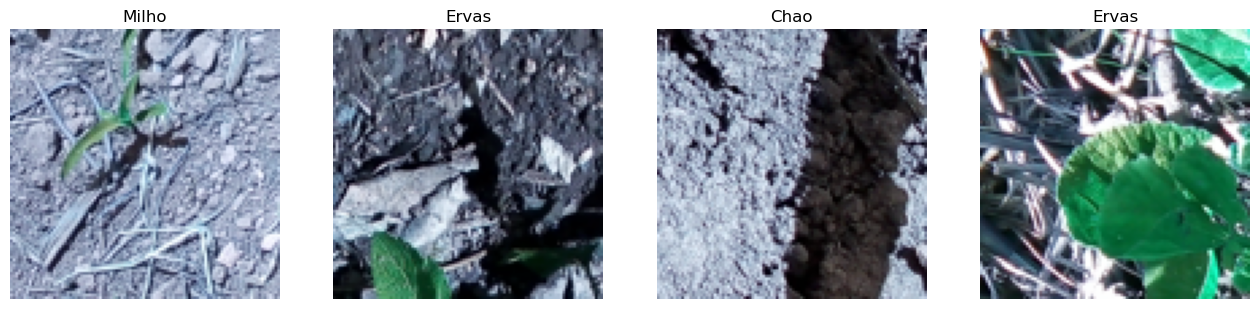

In [ ]:
display_images_horizontally(new_data, num_images=4)

### IV) Prétraitement des données

In [ ]:
from scipy.ndimage import gaussian_filter
# Fonction pour appliquer le filtrage gaussien à une image
def apply_gaussian_filter(image):
    # Appliquer le filtrage gaussien avec un noyau de taille 3x3 et un écart-type de 1
    filtered_image = gaussian_filter(image, sigma=1)
    return filtered_image

# Appliquer le filtrage gaussien à toutes les images dans le DataFrame
new_data['Image'] = new_data['Image'].apply(apply_gaussian_filter)

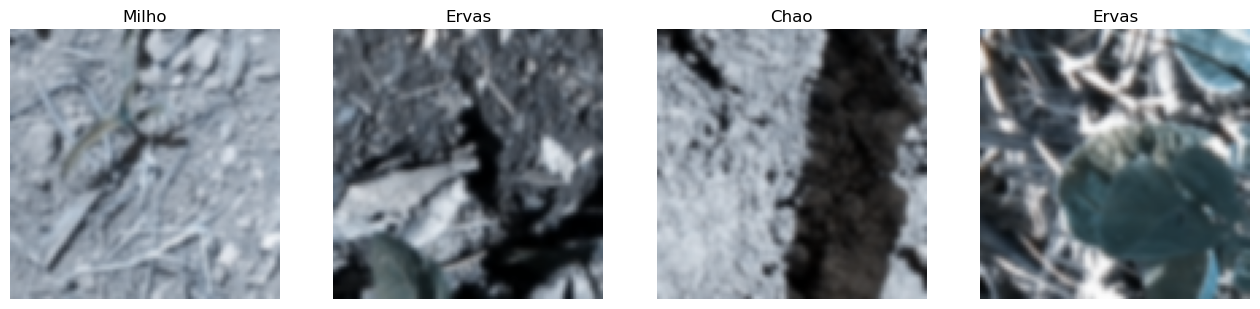

In [ ]:
display_images_horizontally(new_data, num_images=4)

In [ ]:
# Fonction pour convertir une image en niveaux de gris
def convert_to_grayscale(image):
    # Convertir l'image en un tableau numpy
    img_array = np.array(image)
    # Calculer la moyenne des valeurs sur les trois canaux de couleur (rouge, vert, bleu)
    grayscale_image = np.mean(img_array, axis=2, dtype=np.uint8)
    return grayscale_image

# Appliquer la conversion en niveaux de gris à toutes les images dans le DataFrame
new_data['Image'] = new_data['Image'].apply(convert_to_grayscale)


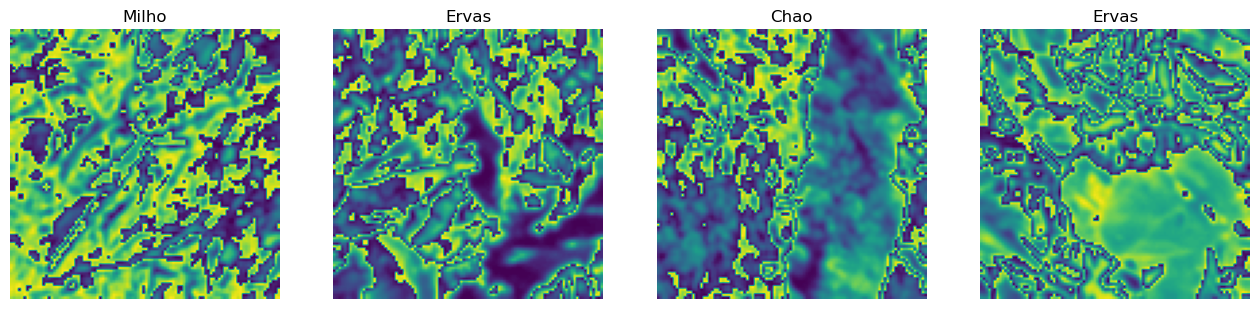

In [ ]:
display_images_horizontally(new_data, num_images=4)

In [ ]:
# Fonction pour normaliser une image
def normalize_image(image):
    # Convertir l'image en un tableau numpy
    img_array = np.array(image)
    # Normaliser les valeurs des pixels en les divisant par la valeur maximale (255 pour les images en niveaux de gris)
    normalized_image = img_array / 255.0
    return normalized_image

# Appliquer la normalisation à toutes les images dans le DataFrame
new_data['Image'] = new_data['Image'].apply(normalize_image)

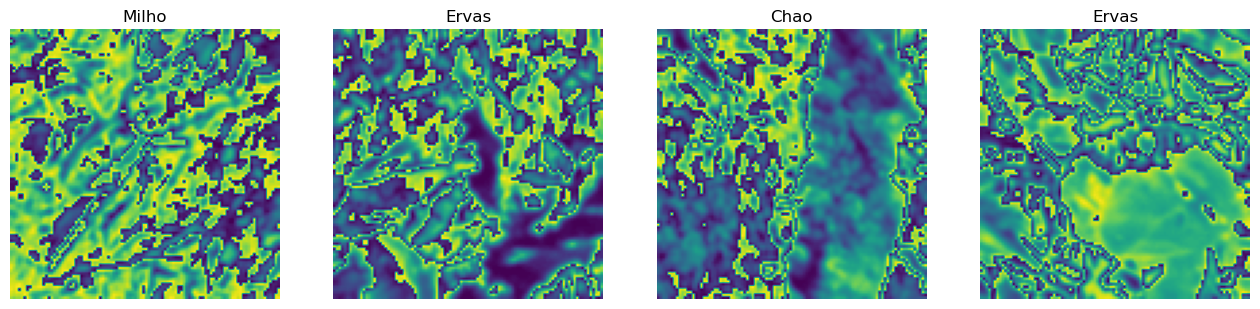

In [ ]:
display_images_horizontally(new_data, num_images=4)

In [ ]:
num_classes = 3
width, height = 48, 48
num_epochs = 5
batch_size = 64
num_features = 64

In [ ]:
import numpy as np

def CRNO(df, dataName, target_width, target_height):
    # Convertir les données d'image en un tableau NumPy
    data_X = np.array([np.array(image) for image in df['Image']], dtype='float32')

    # Redimensionner les images
    data_X_resized = np.array([np.resize(image, (target_width, target_height, 3)) for image in data_X])

    # Normaliser les valeurs des pixels entre 0 et 1
    data_X_rescaled = data_X_resized / 255.0

    data_Y = df['Classe']

    print("{}_X shape: {}, {}_y shape:{}".format(dataName, data_X_rescaled.shape, dataName, data_Y.shape))

    return data_X_rescaled, data_Y

# Spécifiez les dimensions cibles pour le redimensionnement
target_width = 48
target_height = 48

# Appelez la fonction pour les ensembles de données d'entraînement, de validation et de test
train_X, train_Y = CRNO(df_train, "train", target_width, target_height)
val_X, val_Y = CRNO(df_Validation, "val", target_width, target_height)
test_X, test_Y = CRNO(df_test, "test", target_width, target_height)


train_X shape: (366, 48, 48, 3), train_y shape:(366,)
val_X shape: (366, 48, 48, 3), val_y shape:(366,)
test_X shape: (6, 48, 48, 3), test_y shape:(6,)


### model

In [ ]:
from keras.optimizers import Adam, RMSprop, Adagrad
from keras.layers import Dropout

model = Sequential()

# Module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), input_shape=(width,height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.1))  # Ajout d'une couche Dropout

# Module 2
model.add(Conv2D(2*num_features, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))  # Ajout d'une couche Dropout

# Flatten
model.add(Flatten())

# Dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))  # Ajout d'une couche Dropout

# Dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))  # Ajout d'une couche Dropout

# Dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))  # Ajout d'une couche Dropout

# Output layer
model.add(Dense(num_classes, activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_2=0.999, epsilon=1e-7),
             #metrics=['accuracy'])

#RMSprop optimizer
rmsprop_optimizer = RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop_optimizer, metrics=['accuracy'])

# Adagrad optimizer
#adagrad_optimizer = Adagrad(lr=0.001)
#model.compile(loss='categorical_crossentropy', optimizer=adagrad_optimizer, metrics=['accuracy'])

model.summary()

ModuleNotFoundError: No module named 'tensorflow.python.distribute.distribution_strategy_context'

In [ ]:
data_generator = ImageDataGenerator(
                featurewise_center=False,
                featurewise_std_normalization=False,
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=.1,
                horizontal_flip=True)
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                             steps_per_epoch=len(train_X)/batch_size,
                             epochs=num_epochs,
                             verbose=2,
                             callbacks=[es],
                             validation_data=(val_X, val_Y))

### Performances du model

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### Evaluation des performances de test


In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on the set: {:.4f}".format(accuracy_score(test_true, test_pred)))

#### Analyse supplementaire à l'aide de la matrice de confusion

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=None, cmap=plt.cm.Blues, title=None):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    # Utiliser uniquement les étiquettes présentes dans les données
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print("Confusion matrix, without normalization")
    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Nous voulons afficher toutes les marques.
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # et les étiquettes avec les entrées de la liste respectives.
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Faire pivoter les étiquettes des graduations et définir leur alignement.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Parcourir les dimensions des données et créer des annotations textuelles.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels,
normalize=True, title='Normalized confusion matrix')
plt.show()

# XCeption

In [ ]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [64, 128, 256] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x

In [ ]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [ ]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(7, activation='softmax', activity_regularizer=l2(0.001))(x)

    return x

In [ ]:
### Deep Learning models ###
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D
#from tensorflow. keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import densenet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
shape_x = 48
shape_y = 48
#nRows,nCols,nDims = X_train.shape[1:]
#input_shape = (nRows, nCols, nDims)
#classes = np.unique(y_train)
#nClasses = len(classes)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = Model(inputs, outputs)
xception.summary()

In [ ]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_xception = xception.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                             steps_per_epoch=len(train_X)/batch_size,
                             epochs=num_epochs,
                             verbose=2,
                             callbacks=[es],
                             validation_data=(val_X, val_Y))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(history_xception.history['accuracy'])
axes[0].plot(history_xception.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

axes[1].plot(history_xception.history['loss'])
axes[1].plot(history_xception.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(xception.predict(test_X), axis=1)
print("XCeption Model Accuracy on the set: {:.4f}".format(accuracy_score(test_true, test_pred)))

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels,
normalize=True, title='Normalized confusion matrix')
plt.show()

# VGG16

In [ ]:
img_input = Input(shape=(shape_x,shape_y,1))

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

# Classification block
x = Flatten(name='flatten')(x)
x = Dense(4096, name='fc6')(x)
x = Dense(7, name='fc11')(x)
x = Activation('softmax', name='fc11/softmax')(x)

vgg16 = Model(img_input, x, name='vggface_vgg16')

In [ ]:
vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg16 = vgg16.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                             steps_per_epoch=len(train_X)/batch_size,
                             epochs=num_epochs,
                             verbose=2,
                             callbacks=[es],
                             validation_data=(val_X, val_Y))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(history_vgg16.history['accuracy'])
axes[0].plot(history_vgg16.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

axes[1].plot(history_vgg16.history['loss'])
axes[1].plot(history_vgg16.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(vgg16.predict(test_X), axis=1)
print("VGG16 Model Accuracy on the set: {:.4f}".format(accuracy_score(test_true, test_pred)))

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels,
normalize=True, title='Normalized confusion matrix')
plt.show()

# VGG19

In [ ]:
inputs = Input(shape=(shape_x, shape_y, 1))

# Block 1
x = layers.Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv1')(inputs)
x = layers.Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3')(x)
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv3')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv3')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='fc1')(x)
x = layers.Dense(4096, activation='relu', name='fc2')(x)
x = layers.Dense(7, activation='softmax', name='predictions')(x)

vgg19 = models.Model(inputs, x, name='vgg19')
vgg19.summary()

In [ ]:
vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg19 = vgg19.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                             steps_per_epoch=len(train_X)/batch_size,
                             epochs=num_epochs,
                             verbose=2,
                             callbacks=[es],
                             validation_data=(val_X, val_Y))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(history_vgg19.history['accuracy'])
axes[0].plot(history_vgg19.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

axes[1].plot(history_vgg19.history['loss'])
axes[1].plot(history_vgg19.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(vgg19.predict(test_X), axis=1)
print("VGG19 Model Accuracy on the set: {:.4f}".format(accuracy_score(test_true, test_pred)))

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels,
normalize=True, title='Normalized confusion matrix')
plt.show()